In [1]:
# Cell 1: Install and Import Libraries
!pip install torch numpy matplotlib tqdm

In [2]:
%%writefile attention_mechanisms.py
#
# A Python module for implementing and benchmarking different
# attention mechanisms for Transformers.

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import matplotlib.pyplot as plt
import numpy as np

#
# 1. Standard (Full) Attention
#

class FullAttention(nn.Module):
    """
    Implements standard dot-product attention as described in
    "Attention Is All You Need" (Vaswani et al., 2017).

    This has a computational complexity of O(n^2), where n is
    the sequence length.
    """
    def __init__(self, d_model, n_heads):
        super().__init__()
        if d_model % n_heads != 0:
            raise ValueError(f"d_model ({d_model}) must be divisible by n_heads ({n_heads})")
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        # Linear layers for Q, K, V projections
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        # Output linear layer
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        """
        Forward pass for full attention.

        Args:
            Q (torch.Tensor): Query tensor, shape [batch_size, seq_len_q, d_model]
            K (torch.Tensor): Key tensor, shape [batch_size, seq_len_k, d_model]
            V (torch.Tensor): Value tensor, shape [batch_size, seq_len_v, d_model]
                                (seq_len_k and seq_len_v must be the same)
            mask (torch.Tensor): Optional mask.

        Returns:
            (torch.Tensor, torch.Tensor): (Output tensor, Attention weights)
        """
        batch_size = Q.size(0)

        # 1. Project Q, K, V
        # [b, seq_len, d_model] -> [b, seq_len, n_heads, d_head] -> [b, n_heads, seq_len, d_head]
        q = self.q_linear(Q).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        k = self.k_linear(K).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        v = self.v_linear(V).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)

        # 2. Calculate attention scores (scaled dot-product)
        # q: [b, h, seq_len_q, d_head]
        # k.transpose: [b, h, d_head, seq_len_k]
        # scores: [b, h, seq_len_q, seq_len_k]
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)

        # 3. Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # 4. Apply softmax
        attn_weights = F.softmax(scores, dim=-1)

        # 5. Get context vector (weighted sum of values)
        context = torch.matmul(attn_weights, v)

        # 6. Concatenate heads and apply final linear layer
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        output = self.out_linear(context)

        return output, attn_weights

#
# 2. Sparse (Top-k) Attention
#

class SparseAttention(nn.Module):
    """
    Implements a simple "Top-k" sparse attention.
    Each token only attends to the 'k' most similar tokens.
    """
    def __init__(self, d_model, n_heads, k):
        super().__init__()
        self.k = k
        # We can just reuse the FullAttention module's linear layers
        self.full_attention = FullAttention(d_model, n_heads)
        self.d_head = self.full_attention.d_head
        self.n_heads = n_heads
        self.d_model = d_model


    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        seq_len_k = K.size(1)

        # 1. Project Q, K, V (same as full attention)
        q = self.full_attention.q_linear(Q).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        k = self.full_attention.k_linear(K).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        v = self.full_attention.v_linear(V).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)

        # 2. Calculate full attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)

        # 3. THIS IS THE SPARSE PART: Select only Top-k scores
        k_val = min(self.k, seq_len_k)

        top_k_values, _ = scores.topk(k_val, dim=-1)

        k_th_value = top_k_values[..., -1, None]

        sparse_mask = scores < k_th_value

        scores = scores.masked_fill(sparse_mask, -1e9)

        # 4. Apply external mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # 5. Apply softmax
        attn_weights = F.softmax(scores, dim=-1)

        # 6. Get context vector
        context = torch.matmul(attn_weights, v)

        # 7. Concatenate heads and apply final linear layer
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.full_attention.out_linear(context)

        return output, attn_weights

#
# 3. Local (Sliding Window) Attention
#

class LocalAttention(nn.Module):
    """
    Implements Local (Sliding Window) Attention.
    Each token only attends to tokens within a window of size 'w' around it.
    """
    def __init__(self, d_model, n_heads, window_size):
        super().__init__()
        self.window_size = window_size
        self.full_attention = FullAttention(d_model, n_heads)
        self.d_head = self.full_attention.d_head
        self.n_heads = n_heads
        self.d_model = d_model

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        seq_len_q = Q.size(1)
        seq_len_k = K.size(1)

        if seq_len_q != seq_len_k:
            raise ValueError("Local attention requires Q and K to have same sequence length.")

        seq_len = seq_len_q

        # 1. Project Q, K, V (same as full attention)
        q = self.full_attention.q_linear(Q).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        k = self.full_attention.k_linear(K).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        v = self.full_attention.v_linear(V).view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)

        # 2. Calculate full attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)

        # 3. THIS IS THE LOCAL PART: Create a sliding window mask
        indices = torch.arange(seq_len, device=Q.device).unsqueeze(0)
        indices_row = indices.transpose(0, 1)

        distance_matrix = indices_row - indices

        w = self.window_size // 2
        local_mask = (torch.abs(distance_matrix) > w)

        local_mask = local_mask.unsqueeze(0).unsqueeze(0)

        scores = scores.masked_fill(local_mask, -1e9)

        # 4. Apply external mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # 5. Apply softmax
        attn_weights = F.softmax(scores, dim=-1)

        # 6. Get context vector
        context = torch.matmul(attn_weights, v)

        # 7. Concatenate heads and apply final linear layer
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.full_attention.out_linear(context)

        return output, attn_weights

# 4. Benchmarking and Visualization Helpers


def benchmark_attention(attention_module, seq_len, d_model, batch_size, n_runs=20, device='cuda'):
    """
    Benchmarks the speed of an attention module.
    """
    if device == 'cuda' and not torch.cuda.is_available():
        print("CUDA not available. Switching to CPU.")
        device = 'cpu'

    attention_module.to(device)
    attention_module.eval()

    Q = torch.rand(batch_size, seq_len, d_model).to(device)
    K = torch.rand(batch_size, seq_len, d_model).to(device)
    V = torch.rand(batch_size, seq_len, d_model).to(device)

    # Warm-up runs
    for _ in range(5):
        _ = attention_module(Q, K, V)

    start_times = []
    end_times = []

    with torch.no_grad():
        for _ in range(n_runs):
            if device == 'cuda':
                torch.cuda.synchronize()
            start_times.append(time.time())

            _ = attention_module(Q, K, V)

            if device == 'cuda':
                torch.cuda.synchronize()
            end_times.append(time.time())

    avg_time_ms = np.mean([(e - s) * 1000 for s, e in zip(start_times, end_times)])
    return avg_time_ms

def plot_attention_heatmap(attn_weights, title="Attention Weights"):
    """
    Plots the attention weights as a heatmap.
    """
    attn_data = attn_weights.detach().cpu().numpy()

    # Plot first head of the first batch item
    attn_head_0 = attn_data[0, 0, :, :]

    plt.figure(figsize=(8, 6))
    plt.imshow(attn_head_0, cmap='viridis')
    plt.xlabel("Key Positions (Attended To)")
    plt.ylabel("Query Positions (Attending From)")
    plt.colorbar(label="Attention Weight")
    plt.title(title)
    plt.show()

Writing attention_mechanisms.py


In [3]:
# Import Libraries

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# The key import
# It imports all the classes and functions from your .py file
import attention_mechanisms as am

print("Successfully imported 'attention_mechanisms' library!")

Successfully imported 'attention_mechanisms' library!


In [4]:
# Setup Experiment Parameters

# Model Parameters
D_MODEL = 128  # Dimension of the model (must be divisible by n_heads)
N_HEADS = 8    # Number of attention heads
BATCH_SIZE = 16

# Efficient Attention Parameters
K_SPARSE = 32      # Top-k for sparse attention
WINDOW_SIZE = 32   # Window size for local attention

# Benchmarking Parameters
SEQ_LENGTHS = [64, 128, 256, 512, 1024] # Sequence lengths to test
N_RUNS = 20  # Number of runs to average for timing

# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Instantiate Models
models = {
    "Full O(n^2)": am.FullAttention(D_MODEL, N_HEADS).to(DEVICE),
    f"Sparse (k={K_SPARSE})": am.SparseAttention(D_MODEL, N_HEADS, k=K_SPARSE).to(DEVICE),
    f"Local (w={WINDOW_SIZE})": am.LocalAttention(D_MODEL, N_HEADS, window_size=WINDOW_SIZE).to(DEVICE)
}

Using device: cpu


In [7]:
# Run the Performance Benchmark

print("Starting Performance Benchmark")
print(f"Device: {DEVICE}, Runs per test: {N_RUNS}")

# Dictionary to store results: {model_name: [time1, time2, ...]}
results = {name: [] for name in models.keys()}

# Loop over each sequence length
for seq_len in tqdm(SEQ_LENGTHS, desc="Sequence Lengths"):
    print(f"\nTesting sequence length: {seq_len}")

    # Loop over each model
    for name, model in models.items():
        # Run the benchmark
        avg_time_ms = am.benchmark_attention(
            model,
            seq_len=seq_len,
            d_model=D_MODEL,
            batch_size=BATCH_SIZE,
            n_runs=N_RUNS,
            device=DEVICE
        )

        results[name].append(avg_time_ms)
        print(f"  {name}: {avg_time_ms:.2f} ms")

print("\nBenchmark Complete")

Starting Performance Benchmark
Device: cpu, Runs per test: 20


Sequence Lengths:   0%|          | 0/5 [00:00<?, ?it/s]


Testing sequence length: 64
  Full O(n^2): 5.78 ms
  Sparse (k=32): 26.69 ms
  Local (w=32): 7.37 ms

Testing sequence length: 128
  Full O(n^2): 16.60 ms
  Sparse (k=32): 75.77 ms
  Local (w=32): 21.84 ms

Testing sequence length: 256
  Full O(n^2): 88.99 ms
  Sparse (k=32): 301.42 ms
  Local (w=32): 110.59 ms

Testing sequence length: 512
  Full O(n^2): 385.18 ms
  Sparse (k=32): 1070.59 ms
  Local (w=32): 504.55 ms

Testing sequence length: 1024
  Full O(n^2): 1417.15 ms
  Sparse (k=32): 3923.85 ms
  Local (w=32): 1935.26 ms

Benchmark Complete


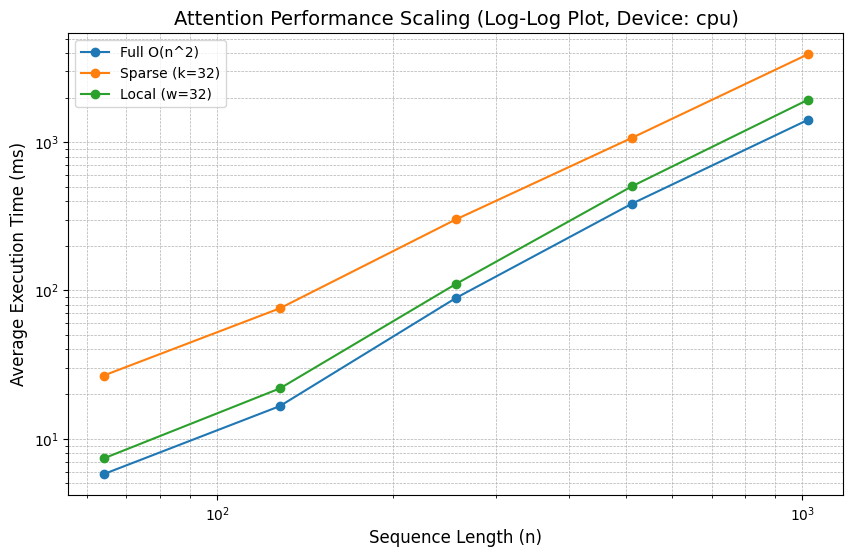

Analysis:
In a log-log plot, O(n^2) should have a slope of 2, while O(n) should have a slope of 1.
Observe how the 'Full O(n^2)' line climbs much faster than the efficient methods.


In [8]:
# Plot the Performance Results

plt.figure(figsize=(10, 6))

for name, times in results.items():
    # Plot seq_len vs. time
    plt.plot(SEQ_LENGTHS, times, label=name, marker='o')

plt.xlabel("Sequence Length (n)", fontsize=12)
plt.ylabel("Average Execution Time (ms)", fontsize=12)
plt.title(f"Attention Mechanism Performance Scaling (Device: {DEVICE})", fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

#  a log-log plot to see the O(n^2) vs O(n) slope clearly
plt.yscale('log')
plt.xscale('log')
plt.title(f"Attention Performance Scaling (Log-Log Plot, Device: {DEVICE})", fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("performance_plot.png")
plt.show()

print("Analysis:")
print("In a log-log plot, O(n^2) should have a slope of 2, while O(n) should have a slope of 1.")
print("Observe how the 'Full O(n^2)' line climbs much faster than the efficient methods.")

Starting Qualitative Analysis (Heatmaps)


<Figure size 640x480 with 0 Axes>

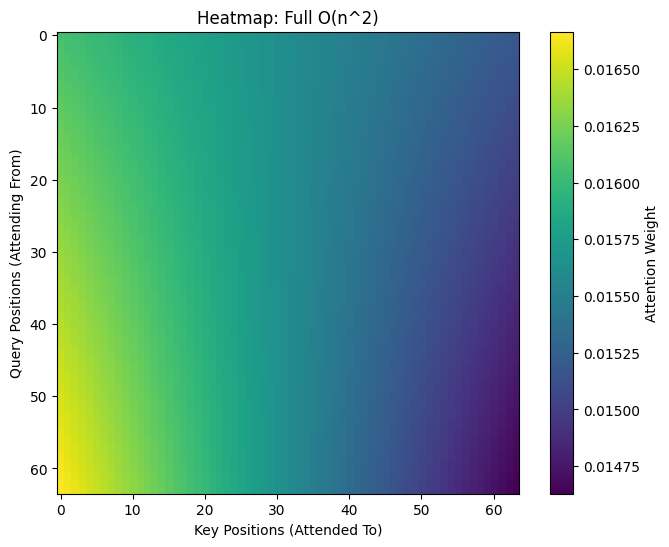

<Figure size 640x480 with 0 Axes>

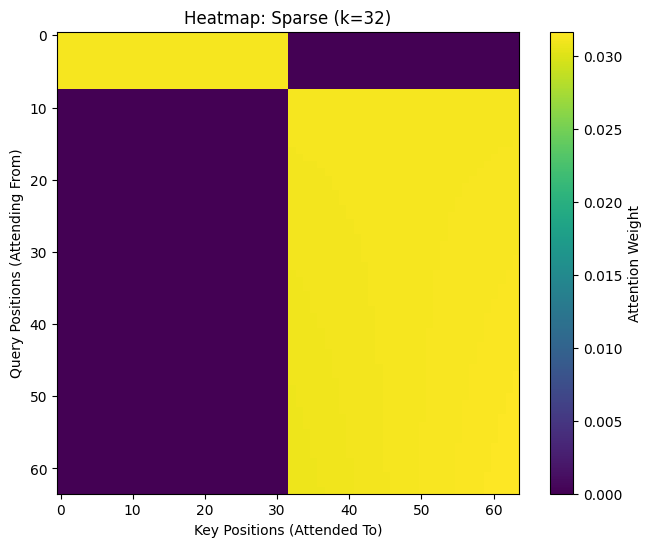

<Figure size 640x480 with 0 Axes>

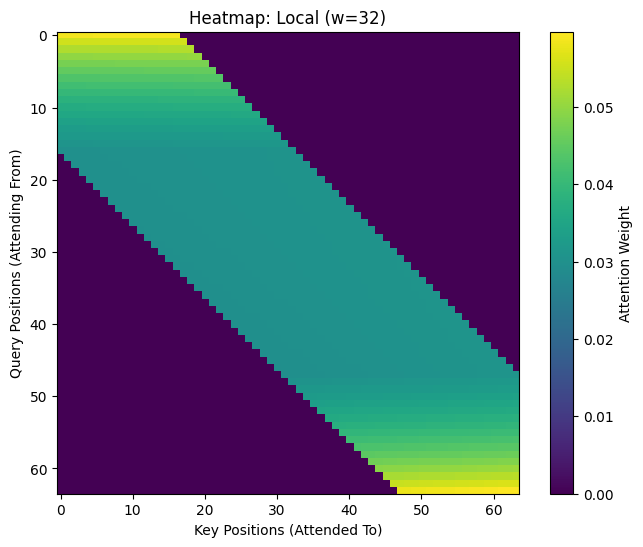

In [10]:
#  Qualitative Analysis (Heatmaps)

print("Starting Qualitative Analysis (Heatmaps)")
# Let's see what each model "looks at"

# Use a shorter sequence for clearer visualization
VIZ_SEQ_LEN = 64

# Create simple, non-random inputs
# A simple ramp tensor from 0 to 1
base_input = torch.linspace(0, 1, VIZ_SEQ_LEN * D_MODEL).view(1, VIZ_SEQ_LEN, D_MODEL).to(DEVICE)
# We can just use the same tensor for Q, K, V
Q_viz = K_viz = V_viz = base_input

# Run each model and get the attention weights
with torch.no_grad():
    for name, model in models.items():
        # Get the weights (output, weights)
        _, attn_weights = model(Q_viz, K_viz, V_viz)

        # Plot the heatmap
        plt.savefig(f"heatmap_{name}.png")
        am.plot_attention_heatmap(attn_weights, title=f"Heatmap: {name}")